# Libs Import


In [1]:
%load_ext autoreload
%autoreload 2
from typing import Optional, Tuple, Literal
import os
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')
%load_ext autoreload
%autoreload 2
# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer, ICNNObsDecoder, StandardICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ?pub_ready_plots.get_mpl_rcParams
# !pip install pub-ready-plots

In [3]:
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)


In [4]:
rc_params

{'text.usetex': False,
 'font.size': 8,
 'font.family': 'serif',
 'font.serif': 'cmr10',
 'mathtext.fontset': 'cm',
 'lines.linewidth': 1.25,
 'axes.linewidth': 1,
 'axes.titlesize': 8,
 'axes.labelsize': 7,
 'axes.unicode_minus': False,
 'axes.formatter.use_mathtext': True,
 'legend.fontsize': 7,
 'xtick.major.size': 1,
 'ytick.major.size': 1,
 'xtick.major.width': 1,
 'ytick.major.width': 1,
 'figure.constrained_layout.use': True}

# Experiment Defnitions

In [5]:
RESULTS_DIR = 'icnn_results_A'
EXP_DIR = {
    'ICNN_LN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal',
    'ICNN_NLN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal_normalised',
    'ICNN_KL': 'experiment_snapshots_mimic_ProbStackedICNN_kl',
    'ICNN_NKL': 'experiment_snapshots_mimic_ProbStackedICNN_kl_normalised',    
    'ICNN_MSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse',
    'ICNN_NMSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse_normalised',
}
PROP_MODELS = ('ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL')
DET_MODELS = ('ICNN_MSE', 'ICNN_NMSE')


ICNN_RENAMES = {
    'ICNN_LN': 'P-ICNN (LN)',
    'ICNN_NLN': 'P-ICNN (NLN)',
    'ICNN_KL': 'P-ICNN (KL)',
    'ICNN_NKL': 'P-ICNN (NKL)',    
    'ICNN_MSE': 'S-ICNN (MSE)',
    'ICNN_NMSE': 'S-ICNN (NMSE)',
}

EXP = 'ICNN_NLN'

# Data Loading

## First Time Loading and Writing to Disk

In [6]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [7]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [8]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [9]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [10]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [11]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [12]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


## Later Loading from Disk

In [13]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


## Split

In [14]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

In [15]:
cooc = obs_mask.T.dot(obs_mask)
cooc

,blood_chemistry.albumin,blood_chemistry.aniongap,blood_chemistry.bicarbonate,blood_chemistry.bun,blood_chemistry.calcium,blood_chemistry.chloride,blood_chemistry.creatinine,blood_chemistry.globulin,blood_chemistry.glucose,blood_chemistry.potassium,...,vital.glucose,vital.heart_rate,vital.mbp,vital.mbp_ni,vital.resp_rate,vital.sbp,vital.sbp_ni,vital.spo2,vital.temperature,weight.weight
blood_chemistry.albumin,10103,9441,9546,9433,8889,9605,9457,247,9512,9603,...,2933,204,149,78,202,148,76,196,62,7
blood_chemistry.aniongap,9441,70120,68995,67654,60134,69058,67533,229,67561,68868,...,22418,1686,1300,586,1673,1297,584,1598,492,84
blood_chemistry.bicarbonate,9546,68995,70515,67650,60356,69395,67422,228,67691,68985,...,22596,1715,1328,600,1698,1325,598,1622,498,86
blood_chemistry.bun,9433,67654,67650,70157,59422,68473,67857,220,66562,68480,...,22032,1682,1316,593,1663,1315,589,1586,493,79
blood_chemistry.calcium,8889,60134,60356,59422,62035,60878,59134,196,60017,60796,...,21006,1498,1132,571,1484,1133,570,1420,439,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vital.sbp,148,1297,1325,1315,1133,1423,1348,5,1234,1428,...,31619,236347,352196,224378,232839,359791,229336,225471,62274,6205
vital.sbp_ni,76,584,598,589,570,644,607,2,589,642,...,11784,113761,223891,224002,112718,229336,229374,108523,26866,1492
vital.spo2,196,1598,1622,1586,1420,1710,1631,5,1543,1738,...,40519,332944,226587,109328,327510,225471,108523,357658,86935,7215
vital.temperature,62,492,498,493,439,523,503,2,482,536,...,16654,91406,62467,26922,90028,62274,26866,86935,97964,3660


<Axes: >

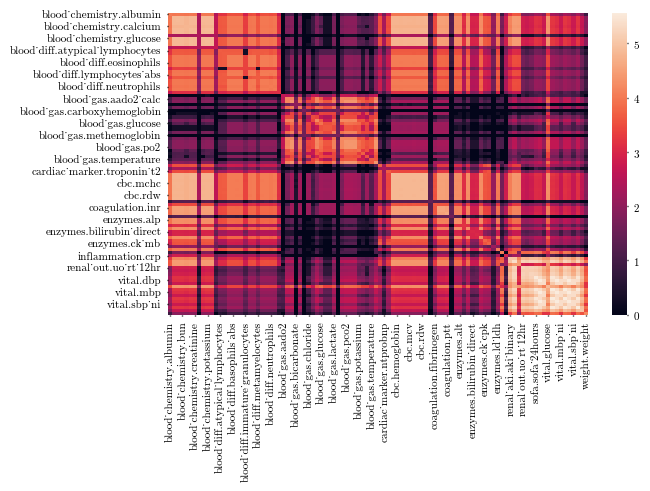

In [16]:

sns.heatmap(np.log10(cooc + 1))


In [17]:
np.mean(obs_mask)

0.08695259245595174

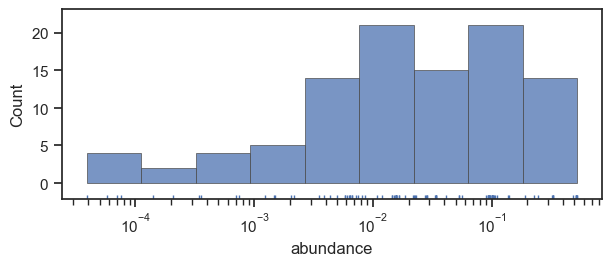

In [18]:
import matplotlib as mpl


p_mask = pd.DataFrame({'abundance': obs_mask.mean(axis=0)})


# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
# sns.rugplot(data=p_mask, x="abundance")
sns.set_theme(style="ticks")
# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
g = sns.rugplot(data=p_mask, x="abundance")
g.set_xscale('log')

sns.histplot(
    p_mask,
    x="abundance", 
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
g.get_figure().set_size_inches(fig_width_in, fig_height_in * 1.5)
g.get_figure().savefig(f"{RESULTS_DIR}/features_abundance.pdf")


In [19]:
obs_mask.shape

(693898, 100)

# Model Configuration

In [20]:

def models(e):
    pmodels = {k: ProbStackedICNNImputer(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',  
                                         positivity='abs', hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
               for k in PROP_MODELS}
    dmodels =  {k: ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',
                                  positivity='abs', hidden_size_multiplier=3, depth=5, key=jrandom.PRNGKey(0)) 
                for k in DET_MODELS}
    return (pmodels | dmodels)[e]
    
def trainers(e):
    return {
        'ICNN_LN': ProbICNNImputerTrainer(loss='log_normal'),
        'ICNN_NLN': ProbICNNImputerTrainer(loss='log_normal', loss_feature_normalisation=True),
        'ICNN_KL': ProbICNNImputerTrainer(loss='kl_divergence'),
        'ICNN_NKL': ProbICNNImputerTrainer(loss='kl_divergence', loss_feature_normalisation=True),
        'ICNN_MSE': StandardICNNImputerTrainer(),
        'ICNN_NMSE': StandardICNNImputerTrainer(loss_feature_normalisation=True)
    }[e]

model = models(EXP)
# trainer = trainers(EXP)

# Training

## ICNN Training

In [21]:
# lr=1e-3
# steps=10000
# train_batch_size=256
# test_batch_size=1024
# # train_batch_size=1
# # test_batch_size=1
# eval_frequency = 10
# model_snapshot_frequency = 100

# optim = optax.novograd(lr)
# opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
# data_train = (obs_val_train, obs_mask_train, art_mask_train)
# data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [22]:
# train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
# test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
# train_history = defaultdict(list)
# test_history = defaultdict(list)
# model_snapshots = {}

In [23]:
# progress = tqdm(range(steps))

# for step, batch_train in zip(progress, train_batches):
#     start = time.time()
#     (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
#     r2_vec =  trainer.model_r_squared(model, *batch_train)
#     r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
#     r2_vec = np.array(r2_vec)
#     train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
#     train_history['R2'].append(r2_vec)
#     train_history['R2_rank5'].append(r2_vec_rank)
#     train_history['loss'].append(train_loss)
#     train_history['n_opt_steps'].append(train_nsteps)
    
#     end = time.time()
#     if (step % eval_frequency) == 0 or step == steps - 1:
#         batch_test = next(test_batches)
#         test_loss, _ = trainer.loss(model, *batch_test)
#         r2_vec_test = trainer.model_r_squared(model, *batch_test)
#         r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
#         r2_vec_test = np.array(r2_vec_test)
#         test_history['loss'].append(test_loss)
#         test_history['R2'].append(r2_vec_test)
#         test_history['R2_rank10'].append(r2_vec_rank_test)

#     if (step % model_snapshot_frequency) == 0 or step == steps - 1:
#         model_snapshots[step] = model
#         append_params_to_zip(model, f'step{step:04d}.eqx', f'{EXP_DIR[EXP]}/params.zip')

#     progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
#                              f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
#                              f"Computation time: {end - start:.2f}, ")
                            

In [24]:
# zip_members(f'{EXP_DIR}/params.zip')

### Dump Training Statistics

In [25]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv')  
# training_stats_melted.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
# training_stats = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv', index_col=[0])  
# training_stats_melted = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv', index_col=[0])  



# g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")
# g2.get_figure().set_size_inches(fig_width_in, fig_height_in)
# g2.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_training_stats.pdf")

## Sklearn Training

In [26]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

# sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [27]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
validation_missingness = 1 - pd.DataFrame(art_mask_test, columns=obs_mask.columns).mean(axis=0)

In [28]:
n_test_censored = pd.Series(prediction_mask.sum(axis=0), index=obs_val.columns)
p_test_censored = n_test_censored / len(prediction_mask)
vars_n300 = n_test_censored[n_test_censored >= 300].index
vars_n300_r = n_test_censored[n_test_censored < 300].index
vars_n300, len(vars_n300)

(Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
        'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
        'blood_chemistry.calcium', 'blood_chemistry.chloride',
        'blood_chemistry.creatinine', 'blood_chemistry.glucose',
        'blood_chemistry.potassium', 'blood_chemistry.sodium',
        'blood_diff.basophils', 'blood_diff.basophils_abs',
        'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
        'blood_diff.lymphocytes', 'blood_diff.lymphocytes_abs',
        'blood_diff.monocytes', 'blood_diff.monocytes_abs',
        'blood_diff.neutrophils', 'blood_diff.neutrophils_abs',
        'blood_gas.aado2_calc', 'blood_gas.baseexcess', 'blood_gas.calcium',
        'blood_gas.fio2_chartevents', 'blood_gas.glucose', 'blood_gas.lactate',
        'blood_gas.pao2fio2ratio', 'blood_gas.pco2', 'blood_gas.ph',
        'blood_gas.po2', 'blood_gas.potassium', 'blood_gas.totalco2',
        'cardiac_marker.ck_mb', 'cardiac_marker.troponin_t2', 'cbc.hematocri

In [29]:
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  
                'blood_chemistry.bicarbonate': 'bc.Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen', 
                'blood_chemistry.calcium': 'bc.Calcium',  'blood_chemistry.chloride': 'bc.Chloride',  
                'blood_chemistry.creatinine': 'bc.Creatinine',  'blood_chemistry.globulin': 'Globulin',  
                'blood_chemistry.glucose': 'bc.Glucose',  'blood_chemistry.potassium': 'bc.Potassium',  
                'blood_chemistry.sodium': 'bc.Sodium',  'blood_chemistry.total_protein': 'Protein Total', 
                'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  
                'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils', 
                'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils', 
                'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',
                'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes', 
                'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes', 
                'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil', 
                'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',
                'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'bg.Bicarbonate',  'blood_gas.calcium': 'bg.Calcium',  
                'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'bg.Chloride',  'blood_gas.fio2': 'FiO2',  
                'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'bg.Glucose',  
                'blood_gas.hematocrit': 'bg.Hematocrit',  'blood_gas.hemoglobin': 'bg.Hemoglobin',  'blood_gas.lactate': 'Lactate', 
                'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',
                'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'bg.Potassium',  'blood_gas.so2': 'sO2', 
                'blood_gas.sodium': 'bg.Sodium',  'blood_gas.temperature': 'bg.Temperature',  'blood_gas.totalco2': 'CO2 total', 
                'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP', 
                'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'cbc.Hematocrit',  'cbc.hemoglobin': 'cbc.Hemoglobin', 
                'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC', 
                'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen', 
                'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',
                'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST', 
                'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',
                'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB', 
                'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',
                'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI', 
                'renal_creat.creat': 'renal.Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',
                'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP', 
                'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'vital.Glucose',  'vital.heart_rate': 'Heart Rate',  
                'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate', 
                'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  
                'vital.temperature': 'vital.Temperature',  'weight.weight': 'Weight'}

## Metrics Evolution with ICNN Training

In [30]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv')
# FIRST TIME - END 
# r2_iters_test_results = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv', index_col=[0])

In [31]:
# r2_iters_test_results

## Metrics of the Last ICNN Snapshot

### Inference with Last ICNN Snapshot (one-time)

In [32]:
# FIRST TIME - BEGIN 
# model = model.load_params_from_archive(f'{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')
# with jax.default_device(jax.devices("cpu")[0]):
#     obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#     (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

# X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
# X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

# X_test_imp_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_imp.csv')
# X_test_std_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_std.csv')
# FIRST TIME - END 

### Ablation Study - Optimiser / max_steps

In [47]:
# FIRST TIME - BEGIN 
model =  models(EXP)#model.load_params_from_archive(f'{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')

sample_index = jrandom.choice(jrandom.PRNGKey(42), a=len(art_mask_test), shape=(500,))
sample_obs_test = jnp.where(art_mask_test[sample_index], obs_val_test[sample_index], 0.)
sample_art_mask_test = art_mask_test[sample_index]
energy0 = eqx.filter_vmap(model.energy0)(sample_obs_test, sample_art_mask_test)

with jax.default_device(jax.devices("cpu")[0]):
    energy = {}
    for opt in tqdm(('adam', 
                'polyak_sgd', 
                'lamb', 
               ), leave=False):
        for lr in tqdm((1e-1, 1e-2, 1e-3, 1e-4), leave=False):
            for max_steps_exp in tqdm((4, 5, 6, 7, 8, 9, 10, 11), leave=False):
                model = eqx.tree_at(lambda m: m.optax_optimiser_name, model, opt)
                _, stats = eqx.filter_vmap(lambda x, m: model.prob_partial_input_optimise(x, m, max_steps=2**max_steps_exp))(sample_obs_test, sample_art_mask_test)
                energy[(opt, lr, max_steps_exp)] = stats.energy

data = defaultdict(list)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [48]:
for (opt, lr, max_steps_exp), energy_vec in energy.items():
    data['opt'].extend([opt] * len(energy_vec))
    data['max_steps_exp'].extend([max_steps_exp] * len(energy_vec))
    data['lr'].extend([lr] * len(energy_vec))
    data['E'].extend((energy_vec).tolist())
    data['delta_E'].extend((energy0 - energy_vec).tolist())

energy_df = pd.DataFrame(data)
energy_df['max_steps'] = 2 ** energy_df['max_steps_exp']

In [49]:
energy_df

,opt,max_steps_exp,lr,E,delta_E,max_steps
0,adam,4,0.1000,11.642128,0.099012,16
1,adam,4,0.1000,10.750767,0.098151,16
2,adam,4,0.1000,10.734852,0.101634,16
3,adam,4,0.1000,11.990250,0.104179,16
4,adam,4,0.1000,10.439460,0.088248,16
...,...,...,...,...,...,...
47995,lamb,11,0.0001,-124.922734,137.315963,2048
47996,lamb,11,0.0001,-95.119162,105.766940,2048
47997,lamb,11,0.0001,-109.858001,120.161337,2048
47998,lamb,11,0.0001,-121.982573,134.059816,2048


In [58]:
energy_df = pd.read_csv('delta_E_nmse_step9999.csv')
# energy_df = pd.read_csv('delta_E_untrained.csv')


<Axes: xlabel='max_steps_exp', ylabel='delta_E'>

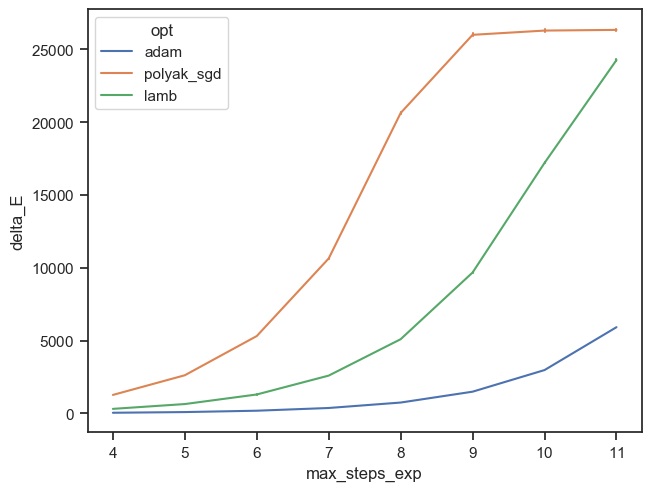

In [59]:
sns.lineplot(
    data=energy_df, x="max_steps_exp", y="delta_E", hue="opt", err_style="bars", errorbar=("se", 2),
)

In [19]:
energy_df

,opt,max_steps_exp,delta_E,max_steps
0,lamb,4,7.290232e+00,16
1,lamb,4,6.213734e+00,16
2,lamb,4,7.023823e+00,16
3,lamb,4,7.039152e+00,16
4,lamb,4,6.722611e+00,16
...,...,...,...,...
7995,lamb,11,1.127025e+10,2048
7996,lamb,11,9.451039e+09,2048
7997,lamb,11,1.066050e+10,2048
7998,lamb,11,1.016004e+10,2048


In [12]:
grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)

# grid.map_dataframe(sns.boxenplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
#                     # line_kws=dict(linewidth=1.5, color="#cde"),
#                     showfliers=False,
#                     fill=False,
#                      gap=0.5)

grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.5, fig_height_in * 3)
grid.savefig(f"{RESULTS_DIR}/X_test_se_df_selection.pdf")

{5: ((Array([[-1.02277651e-03,  6.67091042e-02,  2.77834810e-02, ...,
            6.05670563e-03,  1.23850647e-02,  8.24831267e-02],
          [-9.01573322e-03,  3.04400000e-01,  3.51300000e-01, ...,
            1.79093032e-02, -3.33094227e-03,  8.18177096e-02],
          [-1.46300184e-04,  5.04173642e-02, -3.21499833e-03, ...,
            1.10000000e-01, -8.75690909e-03,  9.81119296e-02],
          ...,
          [ 5.50447912e-03,  6.27235903e-02,  2.07369273e-02, ...,
            6.00000000e-02,  9.41616661e-03,  9.38155674e-02],
          [ 2.19053610e-02,  6.45461292e-02,  2.29106691e-02, ...,
            1.12737821e-02,  2.42905202e-02,  6.26388426e-02],
          [ 7.93717804e-03,  7.18236246e-02,  1.59865750e-02, ...,
            1.09142819e-02,  9.94046216e-04,  4.24800000e-01]],      dtype=float64),
   Array([[9.10485487, 9.00248427, 9.14020249, ..., 8.83524954, 8.86022408,
           8.92605618],
          [9.10576717, 0.01814993, 0.01814993, ..., 8.84298408, 8.85275857,
    

### Load ICNN Inference from Disk (one-time)

In [33]:
vars_n300

In [34]:
all_models_X_test_imp_df = {}
prob_models_X_test_std_df = {}
prob_models_X_var_stats_df = []
all_models_X_test_se = []
all_models_features_stats_df = []
all_models_stats_df = []
PERCENTILES = (95, 90, 80, 70, 60, 50, 25, 10)

for model_name in list(EXP_DIR.keys()) + list(sklearn_imputers.keys()):
    x_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_imp.csv'
    s_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_std.csv'
    if os.path.isfile(x_file):
        X_test_imp_ = pd.read_csv(x_file, index_col=[0])
        all_models_X_test_imp_df[model_name] = X_test_imp_

        # Squared-Errors (per instance)
        X_test_se_ = (X_test_imp_ - np.array(obs_val_test))**2
        X_test_se_ = X_test_se_.where(prediction_mask.astype(bool), other=np.nan)
        X_test_se_ = pd.melt(X_test_se_, value_vars=list(obs_val.columns), value_name='SE')
        X_test_se_ = X_test_se_[X_test_se_.SE.notnull()]
        X_test_se_['Imputer'] = model_name
        all_models_X_test_se.append(X_test_se_)


    if os.path.isfile(s_file):
        X_test_std_ = pd.read_csv(s_file, index_col=[0])
        prob_models_X_test_std_df[model_name] = X_test_std_
        
        X_test_var_ = np.where(prediction_mask.astype(bool), X_test_std_ ** 2, np.nan)
        SE_ = (all_models_X_test_imp_df[model_name] - np.array(obs_val_test)) ** 2
        SE_ = np.where(prediction_mask.astype(bool), SE_, np.nan)
        se_data_ = defaultdict(list)
        for i in range(SE_.shape[1]):
            se_data_['SE'].extend(np.array(SE_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_[r'$\hat{\sigma}^2$'].extend(np.array(X_test_var_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
        se_df_ = pd.DataFrame(se_data_)
        se_df_['Imputer'] = model_name
        
        prob_models_X_var_stats_df.append(se_df_)

    if model_name not in all_models_X_test_imp_df:
        continue

    # R2/MSE (per feature)
    X_test_imp_ = jnp.array(all_models_X_test_imp_df[model_name])
    features_r2_ = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask.T)
    se_ = (np.array(all_models_X_test_imp_df[model_name]) - np.array(obs_val_test)) ** 2
    mse_ = np.nanmean(se_, axis=0, where=prediction_mask.astype(bool))
    features_stats_df_ = pd.DataFrame({r'$R^2$': np.array(features_r2_), 
                                       'MSE': mse_,
                                       'Feature': all_models_X_test_imp_df[model_name].columns,
                                       'Imputer': [model_name] * len(mse_)})

    # r_spearman(SE, sigma2) (per feature)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan)
        features_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_i[mi], sigma2_i[mi]).statistic
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T)]
        features_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_i[mi], sigma2_i[mi]).statistic if mi.sum() > 2 else float('nan')
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T) ]

        features_stats_df_[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(np.log(se_i[mi]), np.log(sigma2_i[mi])).statistic if mi.sum() > 2 else float('nan')
                                         for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T) ]

        # After Transpose, shape: (N_percentiles, n_features)
        features_percentiles = np.vstack([np.percentile(sigma2_i[mi], PERCENTILES)  for (sigma2_i, mi) in zip(X_test_var_.T, prediction_mask.astype(bool).T)]).T

        for percent, percentile in zip(PERCENTILES, features_percentiles):
            prediction_mask_p = np.vstack([mi * (sigma2_i <= p_i) for 
                                           (p_i, sigma2_i, mi) in zip(percentile, X_test_var_.T, prediction_mask.astype(bool).T)]).T
            features_stats_df_[rf'$R^2@P{percent}$'] = np.array(eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask_p.T)).squeeze()
            features_stats_df_[f'MSE@P{percent}'] = np.nanmean(se_, axis=0, where=prediction_mask_p).squeeze()

        
        
        

    all_models_features_stats_df.append(features_stats_df_)

    # R2/MSE (per model)
    features_stats_300_df = features_stats_df_[features_stats_df_.Feature.isin(vars_n300)]
    weighted_avg_R2 = np.average(features_stats_300_df[r'$R^2$'], 
                                 weights=features_stats_300_df['Feature'].map(n_test_censored))
    
    model_stats_df_ = pd.DataFrame({'Imputer': [model_name],
                                    'MSE': [np.nanmean(se_, where=prediction_mask.astype(bool))],
                                    r'$R^2$': [ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MICRO-AVG($R^2$)': [ProbICNNImputerTrainer.r_squared_micro_average(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MACRO-AVG($R^2$)*': [features_stats_300_df[r'$R^2$'].mean()]})

    # corr(SE, sigma2) (per model)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan).flatten()
        m_ = prediction_mask.astype(bool).flatten()
        model_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_.flatten()[m_], X_test_var_[m_]).statistic]
        model_stats_df_[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(np.log(se_.flatten()[m_]), np.log(X_test_var_[m_])).statistic]

        model_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_.flatten()[m_], X_test_var_[m_]).statistic]
    all_models_stats_df.append(model_stats_df_)
    
all_models_X_test_se = pd.concat(all_models_X_test_se)
prob_models_X_var_stats_df = pd.concat(prob_models_X_var_stats_df)
all_models_features_stats_df = pd.concat(all_models_features_stats_df)
all_models_stats_df = pd.concat(all_models_stats_df)

prob_models_X_var_stats_df['LN'] = prob_models_X_var_stats_df['SE'] / prob_models_X_var_stats_df[r'$\hat{\sigma}^2$'] + np.log(prob_models_X_var_stats_df[r'$\hat{\sigma}^2$'])

In [35]:
# all_models_features_stats_df
features_LN = prob_models_X_var_stats_df.groupby(['Imputer', 'Feature'])['LN'].mean()
all_models_features_stats_df = all_models_features_stats_df.set_index(['Imputer', 'Feature'])
all_models_features_stats_df.loc[features_LN.index, 'LN'] = features_LN
all_models_features_stats_df = all_models_features_stats_df.reset_index()
all_models_features_stats_df

In [36]:
models_LN = prob_models_X_var_stats_df.groupby(['Imputer'])['LN'].mean()
all_models_stats_df = all_models_stats_df.set_index('Imputer')
all_models_stats_df.loc[models_LN.index, 'LN'] = models_LN
all_models_stats_df = all_models_stats_df.reset_index()
all_models_stats_df

In [37]:
prob_models_X_var_stats_df.groupby(['Imputer'])['LN'].mean()

In [38]:
all_models_features_stats_df.Imputer.unique()

In [39]:
p_abundance = obs_mask.mean(axis=0)
for name, model_df in all_models_features_stats_df.groupby('Imputer'):
    df = model_df[model_df.Feature.isin(vars_n300)]
    stat = spearmanr(df[r'$R^2$'], df.Feature.map(p_abundance)).statistic
    loc = all_models_stats_df.Imputer == name
    all_models_stats_df.loc[loc, r'$r_\text{Spearman}(R^2, \text{abundance})$'] = stat
    

In [40]:
all_models_stats_df

In [41]:
all_models_features_stats_df

In [42]:
r_classes = [r'$r > 0.3$', r'$r \in [0.1, 0.3]$', r'$r \in [-0.1, 0.1]$', r'$r \leq -0.1$']
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in [-0.1, 0.1]$', r'$R^2 \in (-1, -0.1]$',  r'$R^2 \in (-9, -1]$', r'$R^2 < -9$']
def classify_r(r):
    if r > 0.3:
        return r_classes[0]
    elif r > 0.1:
        return r_classes[1]
    elif r >= -0.1:
        return r_classes[2]
    elif r < -0.1:
        return r_classes[3]
    else:
        return 'NA'

def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R >= -0.1:
        return R_classes[2]
    elif R >= -1:
        return R_classes[3] 
    elif R >= -9:
        return R_classes[4]
    elif R < -9:
        return R_classes[5]
    else:
        return 'NA'

all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'] = all_models_features_stats_df[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'].map(classify_r)
all_models_features_stats_df[r'$r_\text{log}(SE, \hat{\sigma}^2)$ bin'] = all_models_features_stats_df[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$'].map(classify_r)

all_models_features_stats_df[r'$R^2$ bin'] = all_models_features_stats_df[r'$R^2$'].map(classify_R)


In [43]:
for p in PERCENTILES:
    all_models_features_stats_df[rf'$R^2@P{p}$ bin'] = all_models_features_stats_df[rf'$R^2@P{p}$'].map(classify_R)


In [44]:
all_models_features_stats_df

In [45]:
len(vars_n300)

In [46]:
prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'].notnull()]
prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]

prob_models_features_stats_df['Imputer'] = prob_models_features_stats_df['Imputer'].map(ICNN_RENAMES)

r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r(SE, \hat{\sigma}^2)$ bin')


ax = r_bins.plot(y=r_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 1.2, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/prob_icnn_r_bins.pdf")

In [47]:
# prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$'].notnull()]
# prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]

# prob_models_features_stats_df['Imputer'] = prob_models_features_stats_df['Imputer'].map(ICNN_RENAMES)

# r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r_\text{log}(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
# r_bins.columns = ['Imputer', r'$r_\text{log}(SE, \hat{\sigma}^2)$ bin', 'Count']
# r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r_\text{log}(SE, \hat{\sigma}^2)$ bin')


# ax = r_bins.plot(y=r_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
# _ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
# ax.get_figure().set_size_inches(fig_width_in * 1.2, fig_height_in)
# ax.get_figure().savefig(f"{RESULTS_DIR}/prob_icnn_r_bins.pdf")

In [48]:
table_ablation0 = all_models_stats_df.copy()

table_ablation0['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation0.Imputer.unique() if m == m and  m.startswith('P-ICNN')]

table_ablation0 = table_ablation0.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)',  r'MACRO-AVG($R^2$)*', 'LN', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] ].transpose()
table_ablation0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation0.columns))
table_ablation0.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation0.columns))
table_ablation0.columns.name = 'Imputer'
table_ablation0 = table_ablation0.sort_values('MSE', ascending=False, axis=1)
table_ablation0

In [50]:
table_stl_ablation0 = (table_ablation0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              # .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.08, high=0.110,  vmin=0.08, vmax=0.110, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation0

In [51]:
table_ltx_ablation0 = (table_stl_ablation0.to_latex(caption=r"Ablation study on the effect of the probabilistic loss function choice on the performance of "
                                                    r"\texttt{P-ICNN} models. The estimations are made on the validation split."
                                                    r"For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values. "
                                                    r" $r_\text{Pearson}(SE, \hat{\sigma}^2)$ is the correlation between the prediction \gls*{se} and the predicted variance (the higher the better).",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation0)

In [52]:
table_ablation1 = all_models_stats_df.copy()

table_ablation1['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation1.Imputer.unique() if m == m and  m.startswith('S-ICNN')]

table_ablation1 = table_ablation1.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)', r'MACRO-AVG($R^2$)*'] ].transpose()
table_ablation1.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation1.columns))
table_ablation1.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation1.columns))
table_ablation1.columns.name = 'Imputer'
table_ablation1 = table_ablation1.sort_values('MSE', ascending=False, axis=1)
table_ablation1

In [53]:
table_stl_ablation1 = (table_ablation1.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              # .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.08, high=0.110,  vmin=0.08, vmax=0.110, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation1

In [54]:
table_ltx_ablation1 = (table_stl_ablation1.to_latex(caption=r"Ablation study on the effect of the loss function choice on the performance of \texttt{S-ICNN} models. "
                                                    r"First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ "
                                                    r"(higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation1)

In [55]:
S_ICNN = ('ICNN_NMSE', )
P_ICNN = ('ICNN_NKL', 'ICNN_NLN')
# P_ICNN_RENAME = {'ICNN_NKL': 'ICNN (KL)', 
#                  'ICNN_NLN': 'ICNN (LN)'}

final_models_X_test_se = all_models_X_test_se[((all_models_X_test_se.Imputer.str.count('ICNN') == 0) | 
                                               (all_models_X_test_se.Imputer.isin(S_ICNN + P_ICNN)))]

final_models_features_stats_df = all_models_features_stats_df[((all_models_features_stats_df.Imputer.str.count('ICNN') == 0) |
                                                               (all_models_features_stats_df.Imputer.isin(S_ICNN + P_ICNN)))]
final_models_stats_df = all_models_stats_df[((all_models_stats_df.Imputer.str.count('ICNN') == 0) |
                                             (all_models_stats_df.Imputer.isin(S_ICNN + P_ICNN)))]

for df in (final_models_X_test_se, final_models_features_stats_df, final_models_stats_df):
    df['Imputer'] = df['Imputer'].replace(ICNN_RENAMES)   


In [56]:
final_models_stats_df.Imputer.unique()

## Metrics of Sklearn Models

In [57]:
# FIRST TIME - BEGIN 
# sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 
# for sklearn_name, imputed_X_ in sklearn_imputed_X.items():
#     X_test_imp_df = pd.DataFrame(imputed_X_, columns=obs_val.columns)    
#     X_test_imp_df.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv')
# FIRST TIME - END 

In [58]:
all_models_X_test_se.Imputer.unique()

In [59]:
final_models_X_test_se['group'] = final_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
final_models_X_test_se['Feature'] = final_models_X_test_se.variable.map(variable_map)

In [60]:
groups = final_models_X_test_se['group'].unique().tolist()
groups

In [61]:
# enzymes (except Amylase, Bilirubin indirect, CK-CPK)
# renal_creat
# renal_aki
# renal_out
# sofa

X_test_se_df_selection = final_models_X_test_se[final_models_X_test_se.group.isin(['renal_out', 'renal_creat', 'renal_aki', 'sofa'])]

grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)

# grid.map_dataframe(sns.boxenplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
#                     # line_kws=dict(linewidth=1.5, color="#cde"),
#                     showfliers=False,
#                     fill=False,
#                      gap=0.5)

grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.5, fig_height_in * 3)
grid.savefig(f"{RESULTS_DIR}/X_test_se_df_selection.pdf")

In [62]:

all_models_features_stats_df['abundance'] = all_models_features_stats_df.Feature.map(p_abundance)

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[:2]) &
                             all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:2]))]


In [63]:

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[:2]) &
                             all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[2:]))]


In [64]:

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              # all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[1:]) &
                             all_models_features_stats_df[r'$r_\text{log}(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:1]) &
                              (all_models_features_stats_df['LN'] < 0))
]


In [65]:
# TODO: For each feature, exclude the points on the upper part of uncertainty, then recompute the metrics again.

In [66]:
final_models_stats_df.columns

In [67]:
table0 = final_models_stats_df[['Imputer', 'MSE', r'MICRO-AVG($R^2$)', r'MACRO-AVG($R^2$)*']].set_index('Imputer').transpose()
table0 = table0[['P-ICNN (NLN)', 'S-ICNN (NMSE)', 'zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer']]
table0.columns = ['P-ICNN', 'S-ICNN', 'zero', 'mean', 'knn', 'iter']
table0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table0.columns))
table0.columns = list(map(lambda c: c.replace("_", "\\_"), table0.columns))
table0.columns.name = 'Imputer'
table0 = table0.sort_values('MSE', axis=1, ascending=False)
table0

In [68]:
table0_stl = (table0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'MICRO-AVG($R^2$)'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.12, high=0.28,  vmin=0.09, vmax=0.19, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table0_stl

In [69]:
table0_str = (table0_stl.to_latex(caption=r"Comparison between imputation methods. The estimations are made on the validation split."
                                          r"For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in "
                                          r"the test split are excluded, "
                                          r"of which some have $-\infty$ values.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

In [70]:
prob_corr_df = all_models_stats_df.loc[all_models_stats_df.Imputer.isin(['ICNN_LN', 'ICNN_NLN', 'ICNN_NKL', 'ICNN_KL']), ['Imputer', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$', r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$']]

In [71]:
table1_stl = (prob_corr_df.style.format(precision=3).hide())
table1_str = table1_stl.to_latex(caption=r"Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
print(table1_str)

In [72]:
final_models_filtered_features_stats_df = final_models_features_stats_df[final_models_features_stats_df.Feature.isin(vars_n300)]
R_bins = final_models_filtered_features_stats_df.groupby(['Imputer', r'$R^2$ bin'])['Feature'].count().reset_index()
R_bins.columns = ['Imputer', r'$R^2$ bin', 'Count']
R_bins = R_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$ bin')

R_bins = R_bins[R_classes]
R_bins = R_bins.loc[['P-ICNN (NLN)', 'S-ICNN (NMSE)', 'zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer'], :]
R_bins.index = ['P-ICNN', 'S-ICNN', 'zero', 'mean', 'knn', 'iter']

In [73]:
ax = R_bins.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 1.2, fig_height_in * 2)
ax.get_figure().savefig(f"{RESULTS_DIR}/R2_bins.pdf")

In [74]:
final_models_filtered_features_stats_df

In [116]:
mse_cols = ['MSE'] + [f'MSE@P{p}' for p in PERCENTILES]
mse_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_mse_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + mse_cols]
NLN_mse_percentiles = NLN_mse_percentiles.rename(columns=mse_cols_rename)
NLN_mse_percentiles.loc[:, mse_cols_rename.values()] = NLN_mse_percentiles.loc[:, mse_cols_rename.values()].apply(lambda c: c * 100 / NLN_mse_percentiles['P100'], axis=0)
NLN_mse_percentiles['Feature'] = NLN_mse_percentiles.Feature.map(variable_map)
NLN_mse_percentiles = NLN_mse_percentiles.sort_values('Feature')

In [118]:
NLN_mse_percentiles.sort_values('P50').iloc[:15]['Feature']

In [323]:
import colorcet as cc
from scipy.stats import gaussian_kde

from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter, Span
from bokeh.plotting import figure, show, curdoc
from bokeh.sampledata.perceptions import probly
from bokeh.io import output_notebook, export_svgs, export_png
output_notebook()


def ridge(category, data, scale=20):
    return list(zip([category]*len(data), scale*data))

percentiles_ = list(mse_cols_rename.values())
palette = [cc.rainbow[i*15] for i in range(len(percentiles_))]

x = np.linspace(-20, 150, 10000)

source = ColumnDataSource(data=dict(x=x))

p = figure(y_range=percentiles_[1:], width=650, height=400, 
           x_range=(-5, 120), 
           # toolbar_location=None, 
           output_backend="svg"
          )

for i, p_i in enumerate(reversed(percentiles_[1:])):
    pdf = gaussian_kde(NLN_mse_percentiles[p_i], bw_method=0.08)
    y = ridge(p_i, pdf(x))
    source.add(y, p_i)
    p.patch('x', p_i, color=palette[i], alpha=0.6, line_color="black", source=source)

p.add_layout(Span(location=100, dimension='height', line_color='red', line_width=5))

# p.y_range.start = '
p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, 110, 10)))
p.xaxis.formatter = PrintfTickFormatter(format="%d%%")
p.xaxis.axis_label = "%(Relative MSE)"
p.yaxis.axis_label = r"\[\hat{\sigma}^2\]-Percentile (Upper Threshold)"

p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"

p.xaxis.major_label_text_font_size = "10pt"
p.yaxis.major_label_text_font_size = "12pt"



p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis.ticker

# p.axis.minor_tick_line_color = None
# p.axis.major_tick_line_color = None
# p.axis.axis_line_color = None

p.y_range.range_padding = 0.1

show(p)


In [115]:
NLN_mse_percentiles

In [324]:
from matplotlib import colormaps
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe


cmap = colormaps['tab20']
grey = colormaps['Greys'](0.5)
uncertainty_aware_set = sorted(NLN_mse_percentiles.sort_values('P70').iloc[:7]['Feature'])
uncertainty_aware_set_colors = {var: cmap(2*i) for i, var in enumerate(uncertainty_aware_set)}



plt.close()
plt.gcf().clear()    
fig, ax = plt.subplots(figsize=(fig_width_in * 1.5, fig_height_in * 2.5))

pd.plotting.parallel_coordinates(NLN_mse_percentiles[~NLN_mse_percentiles.Feature.isin(uncertainty_aware_set)], 
                                      class_column='Feature', color='grey', linewidth=0.2)
pd.plotting.parallel_coordinates(NLN_mse_percentiles[NLN_mse_percentiles.Feature.isin(uncertainty_aware_set)], 
                                      class_column='Feature', color=uncertainty_aware_set_colors.values(),
                                linewidth=2,
                                path_effects=[pe.Stroke(linewidth=2.5, foreground='black'), pe.Normal()])

# remove the pandas legend
plt.gca().legend_.remove()
plt.grid(True)
plt.ylim(0, 110)
plt.xlabel(r"$\hat{\sigma}^2$-Percentile (Upper Threshold)")
plt.ylabel("%(Relative MSE)")
# plt.title("Highlighted Uncertainty-Aware Dimensions")

# add new legend
# topHandle =    mlines.Line2D([],[], color='red',   ls="-", label="Best")
# midHandleOne = mlines.Line2D([],[], color='blue',  ls="-", label="Next Best")
# lowHandle =    mlines.Line2D([],[], color='black', ls="-", label="Worst")
plt.legend(handles=[Line2D([],[], color=c,  
                           ls="-", label=var, lw=4)  for var, c in uncertainty_aware_set_colors.items()],
           loc='upper left', bbox_to_anchor=(1, 1),
           prop={'size':10})

plt.gcf().set_size_inches(fig_width_in * 1.1, fig_height_in * 2)


plt.savefig(f"{RESULTS_DIR}/LNL_uncertainty_thresholds.pdf")
plt.show()


In [122]:
var_map_r = {label: feature for feature, label in variable_map.items()}

NLN_mse_percentiles.sort_values('P50').iloc[:15]['Feature'].map(var_map_r).tolist()

In [93]:

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                             (all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:1])))
]

In [312]:
NLN_X_var_stats_df = prob_models_X_var_stats_df[prob_models_X_var_stats_df.Imputer == 'ICNN_NLN'].copy()
NLN_X_var_stats_df["log(SE)"] = np.log(NLN_X_var_stats_df["SE"])
NLN_X_var_stats_df[r'$\log{\hat{\sigma}^2}$'] = np.log(NLN_X_var_stats_df[r'$\hat{\sigma}^2$'])

NLN_X_var_stats_VARS = ['enzymes.ck_mb', # 0
                        'enzymes.bilirubin_indirect',
                        'enzymes.ck_cpk',  # 2
                        'inflammation.crp',
                        'blood_chemistry.sodium',
                       'blood_gas.ph',
                         'vital.glucose',
                         'enzymes.ast',
                         'cbc.mchc',
                         'renal_aki.aki_stage_smoothed',
                         'cardiac_marker.ck_mb', # 10
                         'enzymes.alt',
                         'blood_gas.fio2_chartevents',
                         'blood_gas.totalco2',
                         'renal_out.uo_rt_24hr',
                         'cardiac_marker.troponin_t2']

p = sns.regplot(data=NLN_X_var_stats_df[NLN_X_var_stats_df.Feature == NLN_X_var_stats_VARS[0]], 
            y="log(SE)", x=r'$\log{\hat{\sigma}^2}$',
            # y="SE", x=r'$\hat{\sigma}^2$',

             x_bins=np.arange(-5, -0, 0.25), 
            # x_estimator=np.median,
            order=1,
            # lowess=True,
               ci=95, 
            marker="x", color=".3", 
                line_kws=dict(color="r"),
)
p.set_ylabel(r'$\log{(z - \hat{\mu})^2}$')

p.get_figure().set_size_inches(fig_width_in * 0.5, fig_height_in * 2)
p.get_figure().savefig(f"{RESULTS_DIR}/LNL_se_var_ck_mb.pdf")

In [314]:
all_models_features_stats_df.columns

In [321]:
all_models_features_stats_df[all_models_features_stats_df.Imputer == 'ICNN_NLN'].set_index('Feature')[[r'$r_\text{Log-Pearson}(SE, \hat{\sigma}^2)$', 'Imputer']].loc[NLN_X_var_stats_VARS[0]]#.sort_values(ascending=False)

In [276]:
NLN_X_var_stats_df[NLN_X_var_stats_df.Feature == NLN_X_var_stats_VARS[0]].shape

In [146]:
np.arange(-12, -1, 1)

In [108]:
# final_models_filtered_features_stats_df.columns
r2_bin_cols = [r'$R^2$ bin'] + [fr'$R^2@P{p}$ bin' for p in PERCENTILES]
# r2_bin_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_R2_bins_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + r2_bin_cols]
NLN_R2_bins_percentiles = NLN_R2_bins_percentiles.set_index('Feature')
NLN_R2_bins_dist_percentiles = {col: NLN_R2_bins_percentiles.groupby(col)[col].count() for col in r2_bin_cols}
NLN_R2_bins_dist_percentiles = pd.DataFrame(NLN_R2_bins_dist_percentiles)[[r2_bin_cols[0], r2_bin_cols[6]]].transpose()
NLN_R2_bins_dist_percentiles = NLN_R2_bins_dist_percentiles[R_classes]
ax = NLN_R2_bins_dist_percentiles.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, 
                                                  stacked=True, colormap='RdYlGn_r', ylabel='Features Count', width=0.5)
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 0.8 , fig_height_in * 2)
ax.get_figure().savefig(f"{RESULTS_DIR}/NLN_R2_bins_percentiles.pdf")

